In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [22]:
dataset_renaming = {
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
}

subset_renaming = {
    "nonexonic_AND_distal": "Non-exonic\n(distal)",
    "nonexonic_AND_proximal": "Non-exonic\n(proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}

In [30]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    "nonexonic_AND_distal",
    "nonexonic_AND_proximal",
    "5_prime_UTR_variant",
    "3_prime_UTR_variant",
    "non_coding_transcript_exon_variant",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    #"GPN",
    "Enformer",
    "Borzoi",
]

palette = {model: sns.color_palette("tab10")[i] for i, model in enumerate(models)}

def get_model_path(model, modality, dataset, subset):
    supervised_suffix = "LogisticRegression.chrom"
    if model == "CADD":
        predictor = "CADD.plus.RawScore" if modality == "Zero-shot" else f"CADD.{supervised_suffix}"
    elif model in ["Enformer", "Borzoi"]:
        predictor = f"{model}_L2_L2.plus.all" if modality == "Zero-shot" else f"{model}.{supervised_suffix}"
    elif model == "Ensemble":
        if "mendelian" in dataset:
            prefix = "OMIM_Ensemble_v2" 
        else:
            prefix = "Enformer+GPN-MSA+CADD"
        predictor = f"{prefix}.{supervised_suffix}"
    else:
        if "mendelian" in dataset:
            llr_version = "LLR"
            sign = "minus"
        elif "gwas" in dataset:
            llr_version = "absLLR"
            sign = "plus"
        predictor = f"{model}_{llr_version}.{sign}.score" if modality == "Zero-shot" else f"{model}_{llr_version}+InnerProducts.{supervised_suffix}"
    #return f"../../results/dataset/{dataset}/metrics/{subset}/{predictor}.csv"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"
    #return f"../../results/dataset/{dataset}/metrics_by_chrom/{subset}/{predictor}.csv"

In [31]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model,
                    df["score"],
                    df["se"],
                ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,Mendelian traits,Non-exonic\n(distal),Zero-shot,CADD,0.839602,0.000000
1,Mendelian traits,Non-exonic\n(distal),Zero-shot,GPN-MSA,0.824670,0.000000
2,Mendelian traits,Non-exonic\n(distal),Zero-shot,Enformer,0.331308,0.000000
3,Mendelian traits,Non-exonic\n(distal),Zero-shot,Borzoi,0.351558,0.000000
4,Mendelian traits,Non-exonic\n(distal),Linear probing,CADD,0.741511,0.106434
...,...,...,...,...,...,...
75,Complex traits,ncRNA,Zero-shot,Borzoi,0.361533,0.057258
76,Complex traits,ncRNA,Linear probing,CADD,0.305460,0.045432
77,Complex traits,ncRNA,Linear probing,GPN-MSA,0.399139,0.037780
78,Complex traits,ncRNA,Linear probing,Enformer,0.371131,0.053039


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

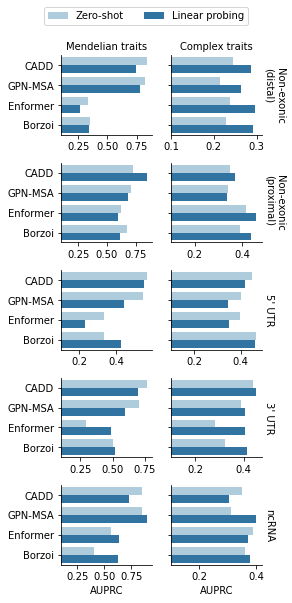

In [60]:
g = sns.catplot(
    data=df.rename(columns={"score": "AUPRC"}),
    y="model",
    x="AUPRC",
    hue="modality",
    row="subset",
    col="dataset",
    kind="bar",
    margin_titles=True,
    sharex=False,
    sharey=True,
    height=1.6,
    aspect=1.3,
    palette="Paired",
    legend_out=False,
)
#sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1.1))
#g._legend.set_title("")

h, l = g.axes[0, 0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(h, l, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.05))

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tight_layout()
plt.savefig("../../results/plots/performance_by_consequence.pdf", bbox_inches="tight")